In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [37]:
EPS = 1e-4
RESULTS_DIR = os.path.join(os.getcwd(), "results")
CROWSPAIRS_RESULTS_DIR = os.path.join(RESULTS_DIR, "crowspairs")
DATA_DIR = os.path.join(os.getcwd(), "data")
CROWSPAIRS_PATH = os.path.join(DATA_DIR, "crows_pairs_anonymized.csv")

gpt2_models = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]
roberta_models = ["roberta-base", "roberta-large"]
flan_t5_models = ["flan-t5-small", "flan-t5-base", "flan-t5-large"]
FILTERS = ["age", "disability", "gender", "nationality", "physical-appearance", "race-color", "religion", "sexual-orientation", "socioeconomic"]
FILTERS = ["_".join(FILTERS)] + FILTERS

In [38]:
def compare_models(results_list, compare_lr=None, baseline=None, title="acc Score by Layer"):
    results_dir = os.path.join(os.getcwd(), "results")
    for result in results_list:
        result_dir = os.path.join(results_dir, result)
        ccs_accs = np.load(os.path.join(result_dir, "ccs_accs.npy"))
        plt.scatter(range(len(ccs_accs)), ccs_accs, label=result)
        #plt.plot(range(len(ccs_accs)), ccs_accs)

    if compare_lr:
        result_dir = os.path.join(os.getcwd(), f"results/{compare_lr}")
        lr_accs = np.load(os.path.join(result_dir, "lr_accs.npy"))
        plt.plot(range(len(lr_accs)), lr_accs, label=f"{compare_lr} LR baseline", color="pink")

    ax = plt.gca()
    ax.legend(bbox_to_anchor=(1.05, 1))

    if baseline:
        plt.axhline(y=baseline, color="pink", linestyle="-")
    # Set range
    plt.ylim(0, 1)
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel("acc Score")

    plt.show()

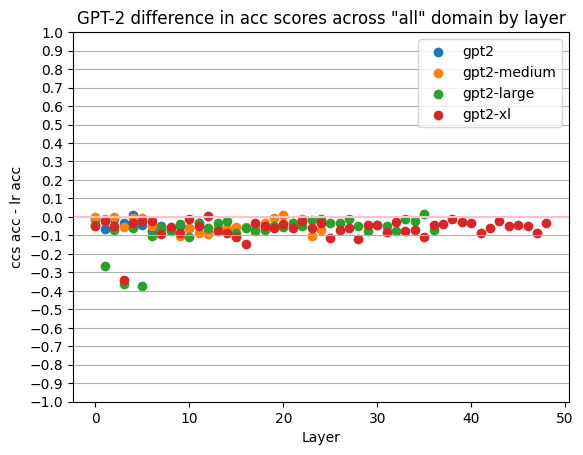

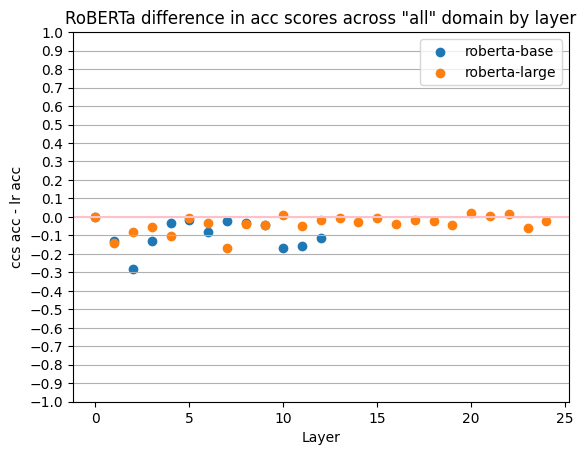

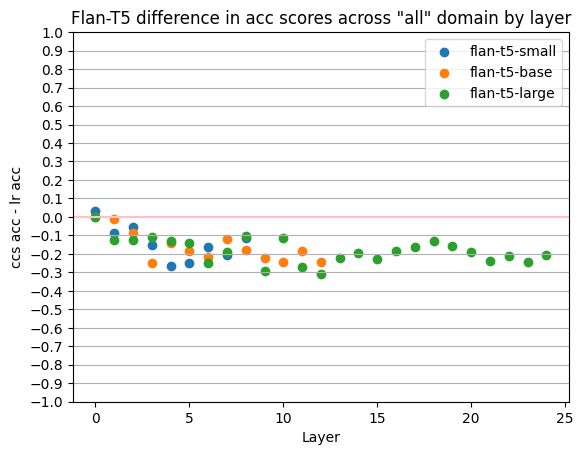

In [39]:
def plot_lr_ccs_diffs(model_names, filter, title=None):
    for model_name in model_names:
        path = os.path.join(CROWSPAIRS_RESULTS_DIR, f"{filter}/{model_name}")
        ccs_accs = np.load(os.path.join(path, "ccs_accs.npy"))
        lr_accs = np.load(os.path.join(path, "lr_accs.npy"))
        plt.scatter(range(len(ccs_accs)), ccs_accs - lr_accs, label=model_name)

    plt.axhline(y=0, color="pink", linestyle="-")

    ax = plt.gca()
    ax.set_yticks(np.arange(-1, 1.1, 0.1))
    ax.grid(axis="y")
    plt.legend()

    if title:
        plt.title(title)
    plt.ylim(-1, 1)
    plt.xlabel("Layer")
    plt.ylabel("ccs acc - lr acc")
    plt.show()

plot_lr_ccs_diffs(gpt2_models, FILTERS[0], title="GPT-2 difference in acc scores across \"all\" domain by layer")
plot_lr_ccs_diffs(roberta_models, FILTERS[0], title="RoBERTa difference in acc scores across \"all\" domain by layer")
plot_lr_ccs_diffs(flan_t5_models, FILTERS[0], title="Flan-T5 difference in acc scores across \"all\" domain by layer")

In [40]:
def single_model_all_domains(model_name, filters, baseline=0.5):
    for filter in filters:
        path = os.path.join(CROWSPAIRS_RESULTS_DIR, f"{filter}/{model_name}")
        ccs_accs = np.load(os.path.join(path, "ccs_accs.npy"))

        plt.scatter(range(len(ccs_accs)), ccs_accs, label=filter)

    ax = plt.gca()
    ax.legend(bbox_to_anchor=(1.05, 1))

    if baseline:
        plt.axhline(y=baseline, color="pink", linestyle="-")

    plt.ylim(0, 1)
    plt.title(f"{model_name} acc scores across all domains")
    plt.xlabel("Layer")
    plt.ylabel("CCS acc")

    plt.show()

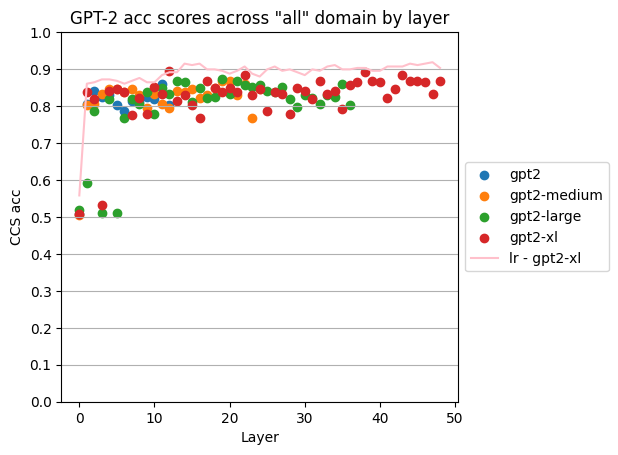

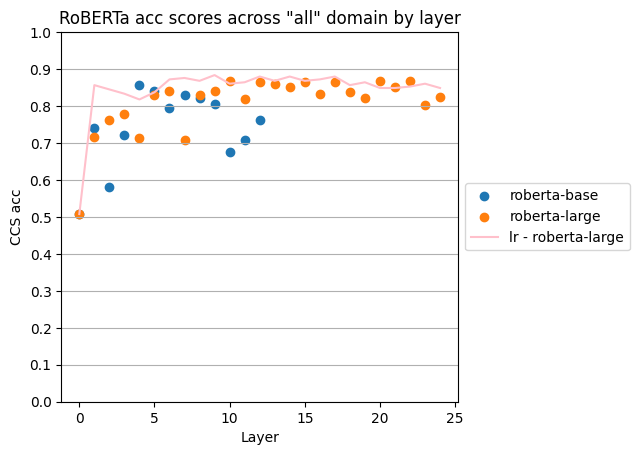

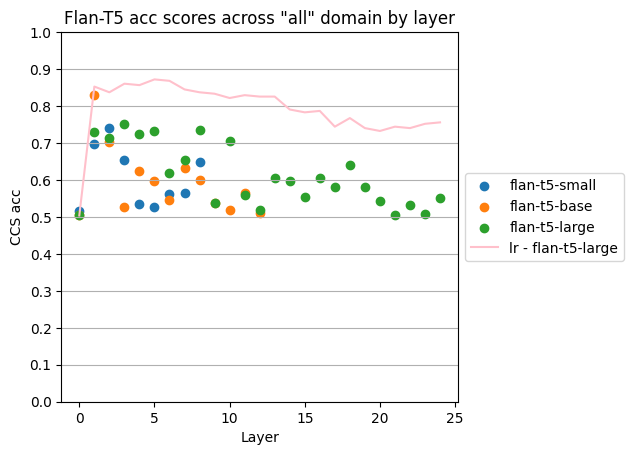

In [41]:
def crowspairs_multiple_models_single_domain(model_names, filter, compare_lr_name=None, baseline=None, title=None):
    for model_name in model_names:
        path = os.path.join(CROWSPAIRS_RESULTS_DIR, f"{filter}/{model_name}")
        ccs_accs = np.load(os.path.join(path, "ccs_accs.npy"))
        plt.scatter(range(len(ccs_accs)), ccs_accs, label=model_name)

        # If we are comparing to a model's LR, scatter it
        if model_name == compare_lr_name:
            lr_accs = np.load(os.path.join(path, "lr_accs.npy"))
            plt.plot(range(len(lr_accs)), lr_accs, label=f"lr - {model_name}", color="pink")

    if baseline:
        plt.axhline(y=baseline, color="pink", linestyle="-")

    ax = plt.gca()
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.grid(axis="y")
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if title:
        plt.title(title)
    plt.ylim(0, 1)
    plt.xlabel("Layer")
    plt.ylabel("CCS acc")
    plt.show()

crowspairs_multiple_models_single_domain(gpt2_models, FILTERS[0], gpt2_models[-1], title="GPT-2 acc scores across \"all\" domain by layer")
crowspairs_multiple_models_single_domain(roberta_models, FILTERS[0], roberta_models[-1], title="RoBERTa acc scores across \"all\" domain by layer")
crowspairs_multiple_models_single_domain(flan_t5_models, FILTERS[0], flan_t5_models[-1], title="Flan-T5 acc scores across \"all\" domain by layer")

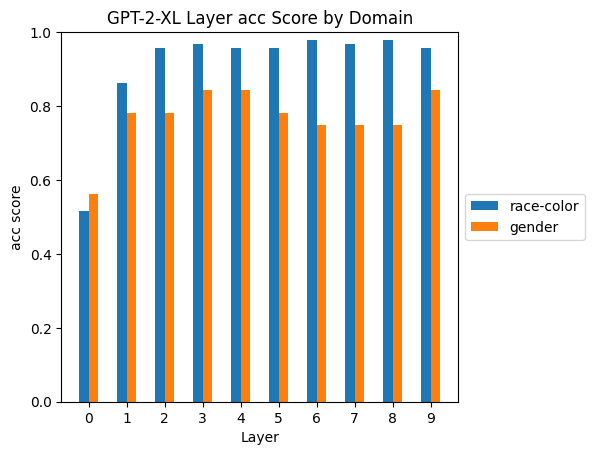

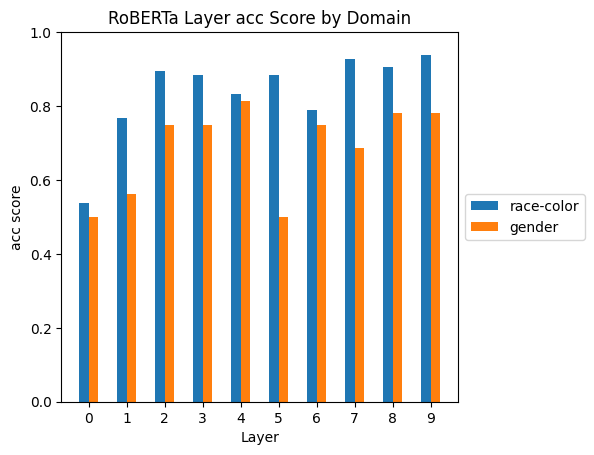

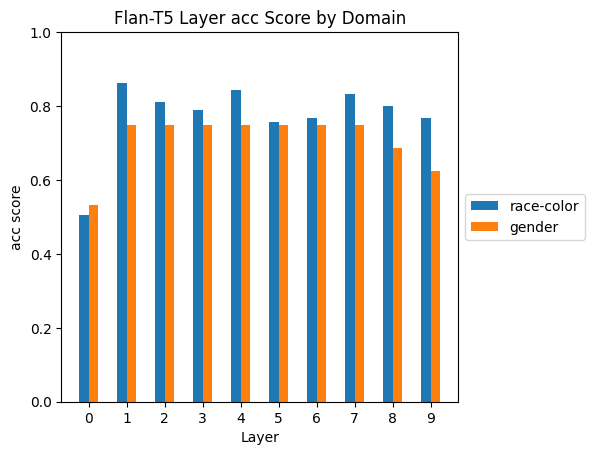

In [42]:
def crowspairs_compare_domains(model_name, filters, n_layers=10, title=None):
    
    results = {}
    for filter in filters:
        path = os.path.join(CROWSPAIRS_RESULTS_DIR, f"{filter}/{model_name}")
        ccs_accs = np.load(os.path.join(path, "ccs_accs.npy"))
        results[filter] = ccs_accs[:n_layers]

    x = np.arange(n_layers)
    width = 0.25
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for filter, accs in results.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, accs, width, label=filter)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel("acc score")
    plt.xlabel("Layer")
    if title:
        ax.set_title(title)
    ax.set_xticks(x + width / 2, x)
    ax.set_ylim(0, 1)

    plt.show()

crowspairs_compare_domains("gpt2-xl", ["race-color", "gender"], title="GPT-2-XL Layer acc Score by Domain")
crowspairs_compare_domains("roberta-large", ["race-color", "gender"], title="RoBERTa Layer acc Score by Domain")
crowspairs_compare_domains("flan-t5-large", ["race-color", "gender"], title="Flan-T5 Layer acc Score by Domain")

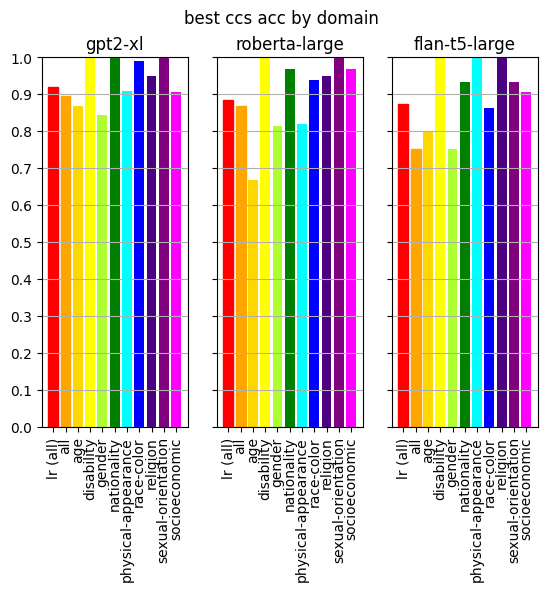

In [54]:
def crowspairs_barchart_all_domains(model_names, filters):
    fig, axes = plt.subplots(1, len(model_names), sharex=True, sharey=True)
    for model_name, ax in zip(model_names, axes):
        # Load data
        max_accs = []
        for filter in filters:
            path = os.path.join(CROWSPAIRS_RESULTS_DIR, f"{filter}/{model_name}")
            ccs_accs = np.load(os.path.join(path, "ccs_accs.npy"))
            if filter == FILTERS[0]:
                lr_accs = np.load(os.path.join(path, "lr_accs.npy"))
                max_accs.append(lr_accs.max())
            max_accs.append(ccs_accs.max())

        # Plot it
        xnames = ["lr (all)"] + filters
        xnames[1] = "all"
        colors = ["red", "orange", "gold", "yellow", "greenyellow", "green", "cyan", "blue", "indigo", "purple", "fuchsia"]
        bar = ax.bar(xnames, max_accs, color=colors)
        bar[0].set_color('red')
        bar[1].set_color('orange')
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.set_title(model_name)
        ax.tick_params('x', labelrotation=90)
        ax.grid(axis="y")

    plt.ylim(0, 1)
    fig.suptitle(f"best ccs acc by domain")
    plt.show()

crowspairs_barchart_all_domains(["gpt2-xl", "roberta-large", "flan-t5-large"], FILTERS)

In [44]:
def count_crowspairs_filters():
    df = pd.read_csv(CROWSPAIRS_PATH)
    df = df[df["stereo_antistereo"] == "stereo"]
    value_counts = df["bias_type"].value_counts()
    biases = list(value_counts.index)
    counts = value_counts.values
    plt.bar(biases, counts)
    plt.xticks(rotation=90)
    plt.title("Number of examples of bias in CrowS-Pairs")
    plt.show()

def average_crowspairs_prompt_length():
    df = pd.read_csv(CROWSPAIRS_PATH)
    df = df[df["stereo_antistereo"] == "stereo"]
    df["len"] = df["sent_more"].str.len()
    bias_len = df.groupby('bias_type')['len'].mean().sort_values()
    biases = ["all"] + list(bias_len.index)
    lengths = [df["len"].mean()] + list(bias_len.values)
    bar = plt.bar(biases, lengths)
    bar[0].set_color('orange')
    plt.xticks(rotation=90)
    plt.title("Average length of each bias group prompt in CrowS-Pairs")
    plt.show()

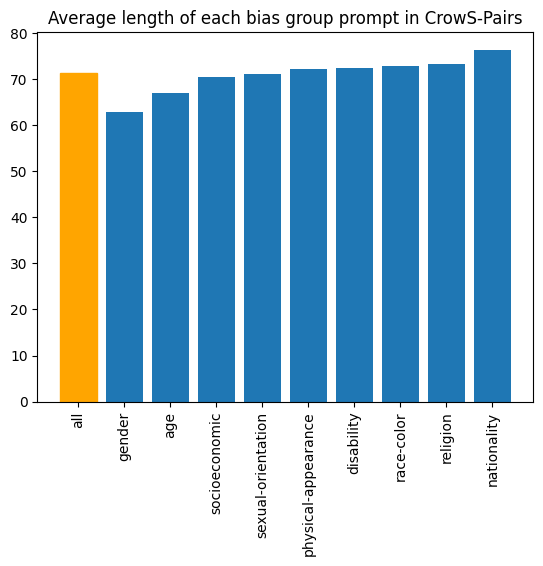

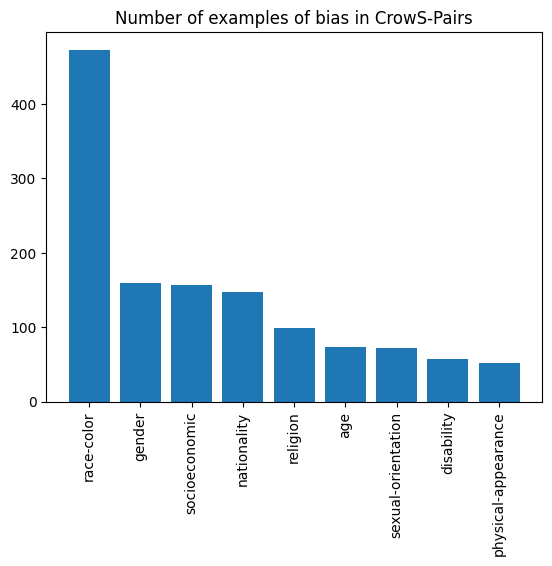

In [45]:
average_crowspairs_prompt_length()
count_crowspairs_filters()

In [46]:
df = pd.read_csv(CROWSPAIRS_PATH)
print(len(df))
df = df[df["stereo_antistereo"] == "stereo"]
len(df)

1508


1290